Variational Autoencoders on Anime Faces

# A Variational Autoencoder (VAE) using the [anime faces dataset by MckInsey666](https://github.com/bchao1/Anime-Face-Dataset).

## Imports

In [ ]:
# Install packages for compatibility with the autograder
!pip install tensorflow==2.8.0 --quiet
!pip install keras==2.8.0 --quiet

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

## Parameters

In [ ]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=1024
LATENT_DIM=512
IMAGE_SIZE=64

## Download the Dataset

Downloading the Anime Faces dataset and save it to a local directory.

In [ ]:
# make the data directory
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/learning-datasets/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

## Prepare the Dataset

Next is preparing the data for training and validation. We've provided you some utilities below.

In [ ]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

You will use the functions above to generate the train and validation sets.

In [ ]:
# get the list containing the image paths
paths = get_dataset_slice_paths("/tmp/anime/images/")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 50
number of batches in the validation set: 13


## Display Utilities

Some utilities to help in visualizing the data.

In [ ]:
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


Let's see some of the anime faces from the validation dataset.

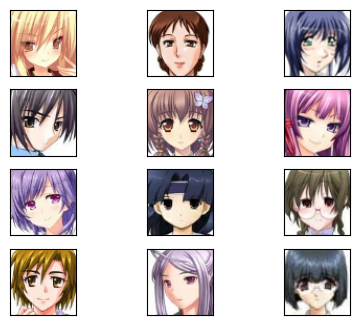

In [ ]:
display_faces(validation_dataset, size=12)

## Build the Model

### Sampling Class

Starting with the custom layer to provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. Recall the equation to combine these:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))


    z = mu + tf.exp(0.5 * sigma) * epsilon

    return  z

### Encoder Layers

Creating the encoder layer to get the mu and sigma from the latent space

In [ ]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """

  x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)


  x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
  batch_3 = tf.keras.layers.BatchNormalization()(x)



  x = tf.keras.layers.Flatten()(batch_3)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(latent_dim)(x)
  sigma = tf.keras.layers.Dense(latent_dim)(x)



  # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
  return mu, sigma, batch_3.shape

### Encoder Model

Feeding the output from the above function to the `Sampling layer` defined earlier. That will have the latent representations that can be fed to the decoder network layer

In [ ]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  inputs = tf.keras.layers.Input(shape=input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)
  z = Sampling()((mu,sigma))
  model = tf.keras.Model(inputs=inputs, outputs=[mu,sigma,z])

  model.summary()
  return model, conv_shape

### Decoder Layers

Defining the decoder layers. This will expand the latent representations back to the original image dimensions. After training the VAE model, decoder model can be used to generate new data by feeding random inputs.

In [ ]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  units = conv_shape[1] * conv_shape[2] * conv_shape[3]

  x = tf.keras.layers.Dense(units)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

  x = tf.keras.layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(3, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(x)



  return x

### Decoder Model


In [ ]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.summary()
  return model

### Kullback–Leibler Divergence

Defining the function to compute the Kullback–Leibler Divergence loss.


In [ ]:
def kl_reconstruction_loss(mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### Putting it all together

defining the whole VAE model.

In [ ]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  inputs = tf.keras.layers.Input(shape=input_shape)

  mu,sigma,z = encoder(inputs)
  print(f"debugging z: {z.shape}")
  x = decoder(z)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  re_loss = kl_reconstruction_loss(mu,sigma)

  model.add_loss(re_loss)





  return model

defining a helper function to return the encoder, decoder, and vae models


In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""


  encoder, conv_shape = encoder_model(latent_dim, input_shape)
  decoder = decoder_model(latent_dim, conv_shape)

  vae = vae_model(encoder, decoder, input_shape)

  return encoder, decoder, vae

Let's use the function above to get the models we need in the training loop.


In [ ]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   1792        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 32, 32, 64)  256         ['conv2d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 128)  73856       ['batch_normalization_16[0]

## Train the Model

configuring the model for training. We defined some losses, the optimizer, and the loss metric below can be experimented with others


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

generating 16 images in a 4x4 grid to show
progress of image generation. We've defined a utility function for that below.

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

starting the training loop.
The general steps are:

* feed a training batch to the VAE model
* compute the reconstruction loss (hint: use the **mse_loss** defined above instead of `bce_loss` in the ungraded lab, then multiply by the flattened dimensions of the image (i.e. 64 x 64 x 3)
* add the KLD regularization loss to the total loss (you can access the `losses` property of the `vae` model)
* get the gradients
* use the optimizer to update the weights


When training the VAE, it might be noticed that there’s not a lot of variation in the faces.


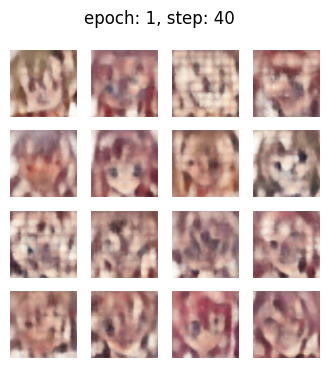

Epoch: 1 step: 40 mean loss = 318.16568
Epoch: 1 step: 41 mean loss = 318.08514
Epoch: 1 step: 42 mean loss = 318.0019
Epoch: 1 step: 43 mean loss = 317.9184
Epoch: 1 step: 44 mean loss = 317.8353
Epoch: 1 step: 45 mean loss = 317.7543
Epoch: 1 step: 46 mean loss = 317.6741
Epoch: 1 step: 47 mean loss = 317.59235
Epoch: 1 step: 48 mean loss = 317.51486
Epoch: 1 step: 49 mean loss = 317.4353
Start of epoch 2


KeyboardInterrupt: ignored

In [ ]:
# Training loop. Display generated images each epoch


epochs = 5


random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)

      # Compute reconstruction loss

      flatten_output = tf.reshape(reconstructed, shape=[-1])
      flatten_input = tf.reshape(x_batch_train, shape=[-1])

      loss = mse_loss(x_batch_train, reconstructed) * 12288

      loss = loss + sum(vae.losses)





    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))

    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

# Plot Reconstructed Images


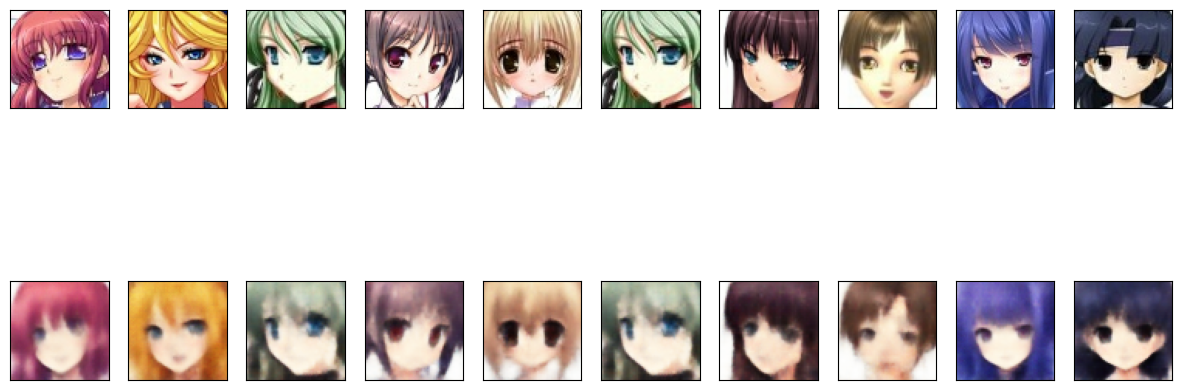

In [ ]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

# Plot Generated Images


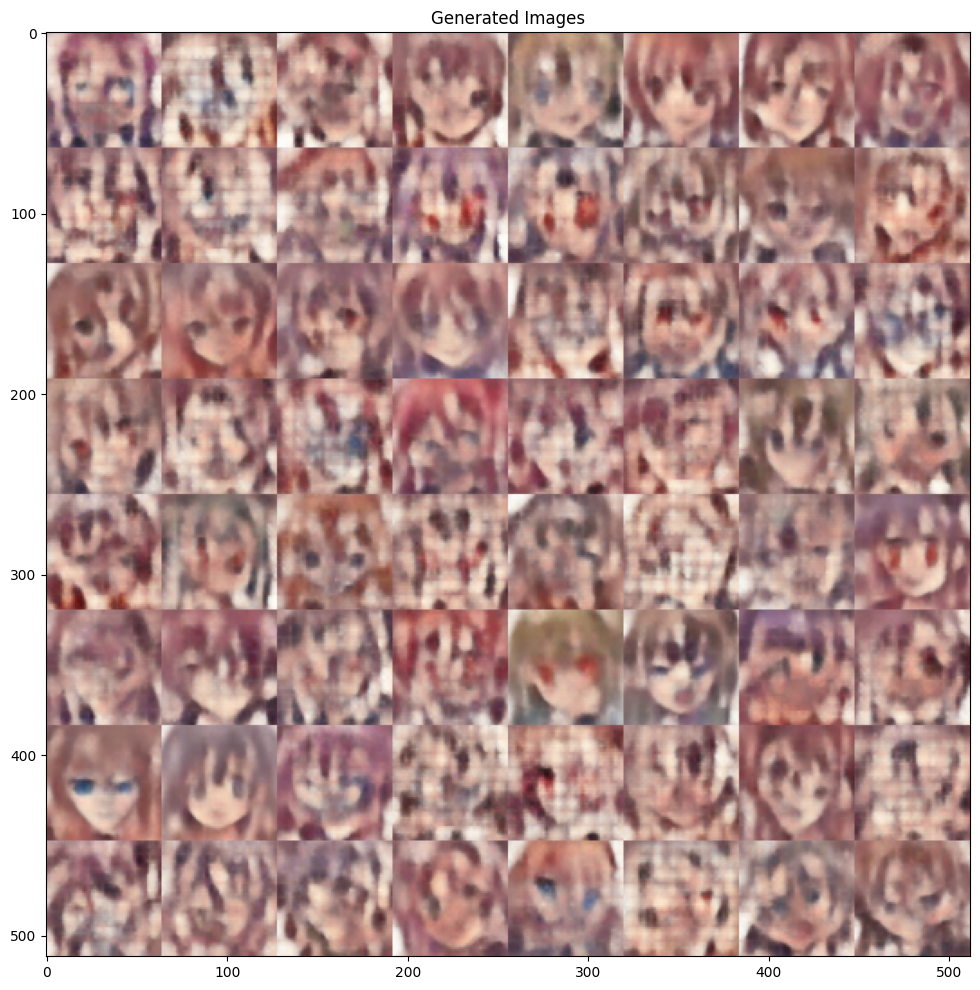

In [ ]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

### Save the Model

In [ ]:
vae.save("anime.h5")